In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
from matplotlib import colors

In [2]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v3')
PATH = os.getcwd()
save_path = '\\Individual_Figures'
with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 100 #number of trials in each block 
num_blocks = 6
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

In [3]:
analysis_pull_list

['Sub1']

In [52]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.dark_blue
box_color2 = wheel.dark_red
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'


### Functions

In [53]:
def jitter(arr, data):
    if data.ndim >1:
        arr = np.tile(arr,(np.shape(data)[1],1))
        arr = arr + np.random.normal(0,0.05, np.shape(data.T))
    else:
        arr = arr + np.random.normal(0,0.05, np.shape(data.T))
    return arr.T # Need to transpose to get it right

In [54]:
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              'figure.facecolor': 'black',
              'axes.facecolor' : 'black'
              }
    plt.rcParams.update(params)

In [55]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None, savename=None, save = False):
    if save:
        update_params('w')
    else:
       update_params('black')
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*2
        xlocs = xlocs + shift_direction*box_widths*2
        print(box_xlocs)
        if shift_direction == 1:
            props = [two_props,two_whisk,two_cap,two_median]
        else:
            props = [three_props,three_whisk,three_cap,three_median]

    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_red,wheel.dark_blue]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+'\\Figures\\'+savename, dpi = 400, transparent = True, bbox_inches='tight')

In [56]:
#%% Double Box plot with dots Function
def double_boxplot(data1,data2, xlocs, ylocs, figsize=(8,4),data_labels = None, xlab=None, ylab=None, title=None, savename=None, save = False):
    if save:
        update_params('w')
    else:
        update_params('black')
    plt.figure(dpi = 125, figsize = (8,4))
    box_widths = 0.3
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    total = np.concatenate((data1, data2))
    ax.plot(jitter(xlocs-box_widths/2, np.shape(data1)).T, data1.T,color = '0.8', marker= 'o', markerfacecolor = 'black', linewidth =1.5, alpha=0.5 )
    ax.plot(jitter(xlocs+box_widths/2, np.shape(data2)).T, data2.T,color = '0.8', marker= 'o', markerfacecolor = 'black', linewidth =1.5, alpha=0.5 )
    #bplot two  #block number, dyad, right/left
    ax.boxplot(data1, positions=xlocs+box_widths/2, patch_artist=True, boxprops = two_props, whiskerprops = two_whisk, 
                capprops = two_cap, medianprops = two_median, showfliers=False, widths = box_widths)
    #bplot three
    ax.boxplot(data2, positions = xlocs-box_widths/2, patch_artist=True, boxprops = three_props, whiskerprops = three_whisk,
                capprops = three_cap, medianprops=three_median, showfliers = False, widths = box_widths)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    labels = data_labels
    colors = [wheel.dark_blue, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+'\\Figures\\'+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

Pickle

In [57]:
#%% Pickle load 
# CHANGE
player_wins = np.zeros((num_subjects, num_blocks))
player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_wins = np.zeros((num_subjects, num_blocks))
perc_player_indecisions = np.zeros((num_subjects, num_blocks))
trial_table = np.empty((num_subjects, tot_trials, 4), int)
player_reach_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([num_subjects,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([num_subjects,reaction_trials])*np.nan 
rt_trial_start = np.zeros((num_subjects,reaction_trials))*np.nan 
timing_reach_time = np.zeros([num_subjects,reaction_trials])*np.nan 
hand_pos_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_reach_time = np.zeros((num_subjects,num_blocks,num_trials))
agent_target_selection = np.zeros((num_subjects,num_blocks,num_trials))
player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
player_left_start_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 

for i in range(num_subjects):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))
    player_wins[i,:] = pickle.load(open(data_path + f'{subname}_player_wins.pkl', 'rb'))
    perc_player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions.pkl', 'rb'))
    perc_player_wins[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins.pkl', 'rb'))
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    agent_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_reach_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_player_incorrect_decisions.pkl', 'rb'))
    player_left_start_time[i,:] = pickle.load(open(data_path + f'{subname}_player_left_start_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
agent_left_start_time = agent_reach_time - 300

### Calculations

Reaction and Reaction Movement Time

In [58]:
#%% Calculate RT means and sds
rt_mean = np.zeros(num_subjects)
rt_sd = np.zeros(num_subjects)
rmt_mean = np.zeros(num_subjects)
rmt_sd = np.zeros(num_subjects)

# Reaction time
for i in range(num_subjects):
    rt_mean[i] = np.nanmean(reaction_time[i,25:])
    rt_sd[i] = np.nanstd(reaction_time[i,25:])
    rmt_mean[i] = np.nanmean(reaction_movement_time[i,25:])
    rmt_sd[i] = np.nanstd(reaction_movement_time[i,25:])


In [59]:
np.nanmean(rmt_sd)

30.64052218876173

Timing Movement Time

In [60]:
#%% Calculate RT means and sds
timing_mean = np.zeros(num_subjects)
timing_sd = np.zeros(num_subjects)
# Reaction time
for i in range(num_subjects):
    timing_mean[i] = np.mean(timing_reach_time[i,25:])
    timing_sd[i] = np.std(timing_reach_time[i,25:])


Experiment reach and decision times

In [61]:
# Actual trials
agent_mean_reach_time = np.nanmean(agent_reach_time,axis = 2)
agent_sd_reach_time = np.nanstd(agent_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_left_start_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_left_start_time, axis =2)
player_mean_reach_time = np.nanmean(player_reach_time,axis=2)
player_sd_reach_time = np.nanstd(player_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_left_start_time,axis=2)
player_sd_decision_time = np.nanstd(agent_reach_time,axis = 2)


Reach Times on Indecisions

In [62]:
#%% Find agent reach times for player indecisions
agent_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
indecision_index = np.argwhere(player_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_reach_time_on_indecisions[i,j,k] = agent_reach_time[i,j,k]
    player_reach_time_on_indecisions[i,j,k] = player_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_left_start_time[i,j,k]
    c+=1
for i in range(num_subjects):
    for j in range(num_blocks):
        agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_reach_time_on_indecisions[i,j,:])
        player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
        player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])

agent_mean_left_time_on_indecisions = agent_mean_reach_time_on_indecisions - 300

Gamble and reaction calculations

In [63]:
# Go through gamble reach times and then wins, indecisions, losses separately for reaction and gambles
#%% Average agent mean reach time on gamb

gamble_left_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_reach_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_left_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_index = np.argwhere(abs(agent_left_start_time-player_left_start_time)<250)
for i,j,k in gamble_index:
    gamble_left_target_time[i,j,k] = player_left_start_time[i,j,k]
    gamble_reach_target_time[i,j,k] = player_reach_time[i,j,k]
    agent_reach_time_gambles[i,j,k] = agent_reach_time[i,j,k]
    agent_left_time_gambles[i,j,k] = agent_reach_time[i,j,k] - 300

#%% Count wins where they gambled, wins where they reacted, losses when they gambled, losses when they reacted, and indecisions
## 200 is probably too small for two choice reaction 
gamble_index = np.argwhere(player_left_start_time - agent_left_start_time<250)
reaction_index = np.argwhere((player_left_start_time - agent_left_start_time>=250))
did_not_leave_start_index = np.argwhere((np.isnan(player_left_start_time))) # This indiddex is for if they left the start too early, or didn't leave at all

#left_out = np.argwhere()
gamble_wins = np.zeros((num_subjects, num_blocks))
gamble_indecisions = np.zeros((num_subjects, num_blocks))
gamble_losses = np.zeros((num_subjects, num_blocks))
reaction_wins = np.zeros((num_subjects, num_blocks))
reaction_indecisions = np.zeros((num_subjects, num_blocks))
reaction_losses = np.zeros((num_subjects, num_blocks))
for i,j,k in gamble_index:
    if player_decision_array[i,j,k] == 1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        gamble_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        gamble_losses[i,j] += 1
    else:
        print('none')
  
for i,j,k in reaction_index:
    if player_decision_array[i,j,k] ==  1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        reaction_losses[i,j] += 1
    else:
        print("none triggerd")
for i,j,k in did_not_leave_start_index:
    if player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j]+=1 # If they ended up not making it, it was likely due to reaction indecision
    #lif player_decision_array[i,j,k]*agent_target_selection[i,j,k]>0:
       
perc_gamble_wins = gamble_wins/num_trials*100
perc_gamble_losses = gamble_losses/num_trials*100
perc_gamble_indecisions = gamble_indecisions/num_trials*100
perc_reaction_wins = reaction_wins/num_trials*100
perc_reaction_losses = reaction_losses/num_trials*100
perc_reaction_indecisions = reaction_indecisions/num_trials*100


In [64]:
perc_player_indecisions

array([[ 5., 14.,  8., 47., 34., 11.]])

In [65]:
# Calculate the average reach time for each subject when they gamble for each condition 
gamble_index = np.argwhere(player_left_start_time-agent_left_start_time<200)
reaction_index = np.argwhere((player_left_start_time-agent_left_start_time>=200))
did_not_leave_start_index = np.argwhere((np.isnan(player_left_start_time)))
gamble_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
reaction_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
for i,j,k in gamble_index:
    gamble_decision_times[i,j,k] = player_left_start_time[i,j,k]
for i,j,k in reaction_index:
    reaction_decision_times[i,j,k] = player_left_start_time[i,j,k]
# get means
gamble_decision_time_means = np.nanmean(gamble_decision_times, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )

Trial By Trial calculations

In [66]:
# Need to reshape to place each condition after each other
player_decision_time_all_conditions = np.reshape(player_left_start_time, (num_subjects,tot_trials)) # This takes each condition and places it behind the previous one

### Figures

Reaction time, reaction movement time, timing distributions

In [67]:
update_params('w')

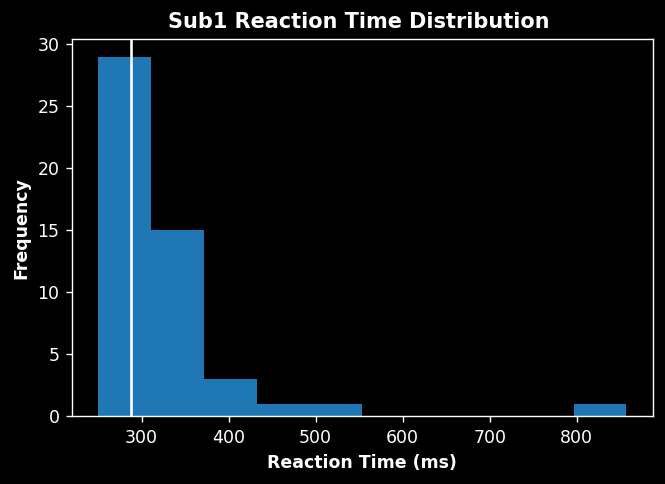

In [68]:
#%% Plot reaction time and rmt distribution 
for i in range(num_subjects):
    plt.figure(dpi=125)
    ax = plt.subplot()
    ax.hist(reaction_time[i,:], bins = 10) #Only use trials 25-50
    ax.axvline(rt_mean[i], c=wheel.white)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Reaction Time (ms)')
    ax.set_title(f'Sub{i+1} Reaction Time Distribution ')
plt.show()

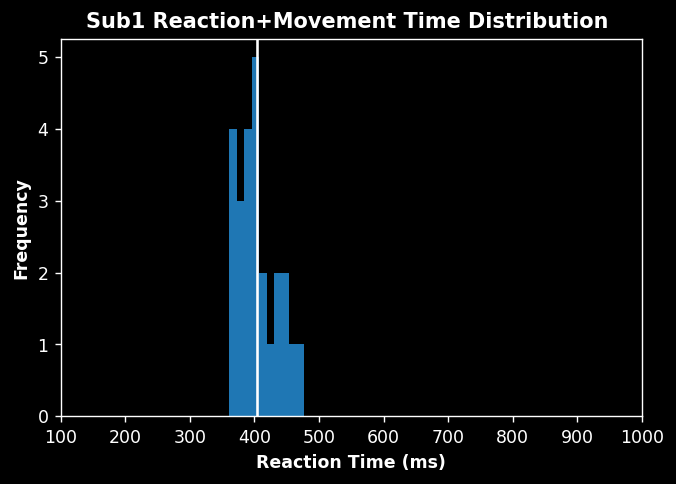

In [69]:
# Plot reaction movement time distribution
for i in range(num_subjects):
    plt.figure(dpi = 125)
    ax = plt.subplot()
    ax.hist(reaction_movement_time[i,25:], bins = 10)
    ax.axvline(rmt_mean[i], c=wheel.white)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Reaction Time (ms)')
    ax.set_title(f'Sub{i+1} Reaction+Movement Time Distribution ')
    ax.set_xlim(100,1000)
plt.show()

In [70]:
# # Timing distribution 
# # Plot reaction movement time distribution
# for i in range(num_subjects):
#     plt.figure(dpi = 125)
#     ax = plt.subplot()
#     ax.hist(timing_reach_time[i,25:], bins = 10)
#     ax.axvline(timing_mean[i], c='black')
#     ax.set_ylabel('Frequency')
#     ax.set_xlabel('Reaction Time (ms)')
#     ax.set_title(f'Sub{i+1} Timing Reach Time Distribution')
#     ax.set_xlim(1000,2200)
# plt.show()


Reach and decision time plots

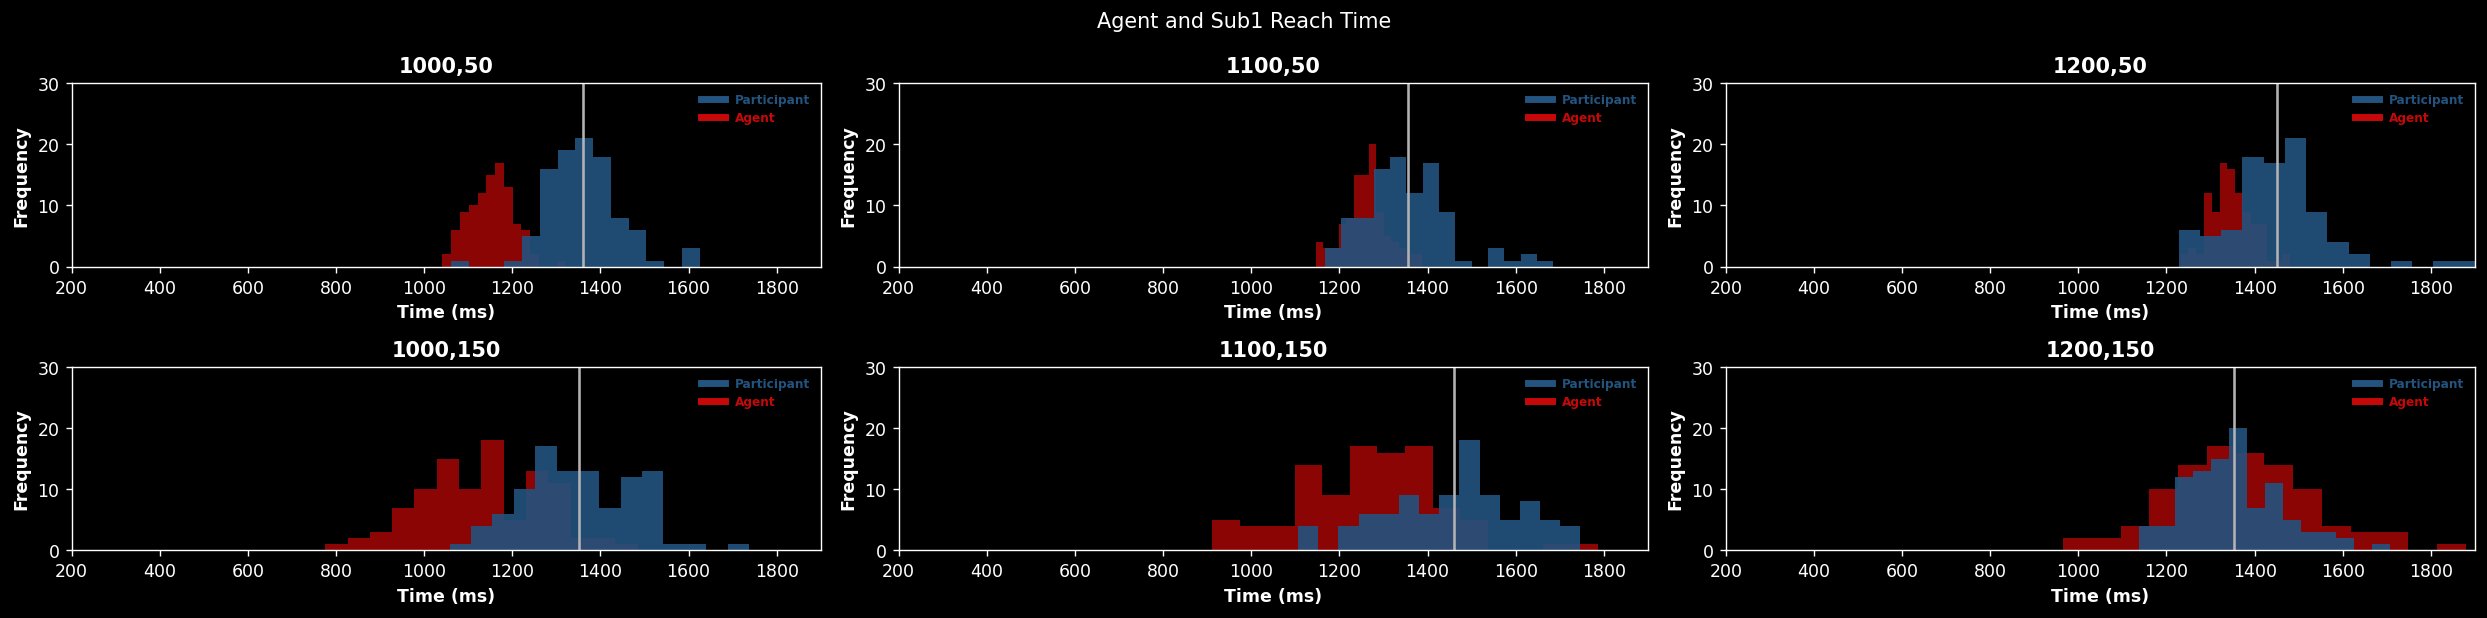

In [71]:
#%% Plot Agent and Player Reach Time Distribution 
for i in range(num_subjects):
    fig,axs = plt.subplots(2,3, figsize = (20,5), dpi = 125)
    c = -1
    d = 0
    for j in range(num_blocks):
        c+=1
        axs[c,d].hist(agent_reach_time[i,j,:], histtype = 'stepfilled', color=wheel.dark_red, alpha = 0.7, bins = 14)
        axs[c,d].hist(player_reach_time[i,j,:], histtype = 'stepfilled', color = wheel.dark_blue, alpha = 0.9, bins = 14)
        axs[c,d].axvline(player_mean_reach_time[i,j], c= wheel.light_grey)
        axs[c,d].set_xlim(200,1900)
        axs[c,d].set_ylim(0,30)
        axs[c,d].set_xlabel('Time (ms)')
        axs[c,d].set_ylabel('Frequency')
        labels = ["Participant", "Agent"]
        colors = [wheel.dark_blue, wheel.dark_red]
        dv.Custom_Legend(axs[c,d], labels, colors, fontsize = 7)
        axs[c,d].set_title(trial_block_titles[j])
        if c == 1:
            d += 1
            c = -1
    fig.suptitle(f'Agent and Sub{i+1} Reach Time', c = 'white')
    plt.tight_layout()
    plt.savefig(PATH+save_path+f'\\Sub{i+1}\\reach_time_distributions', dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

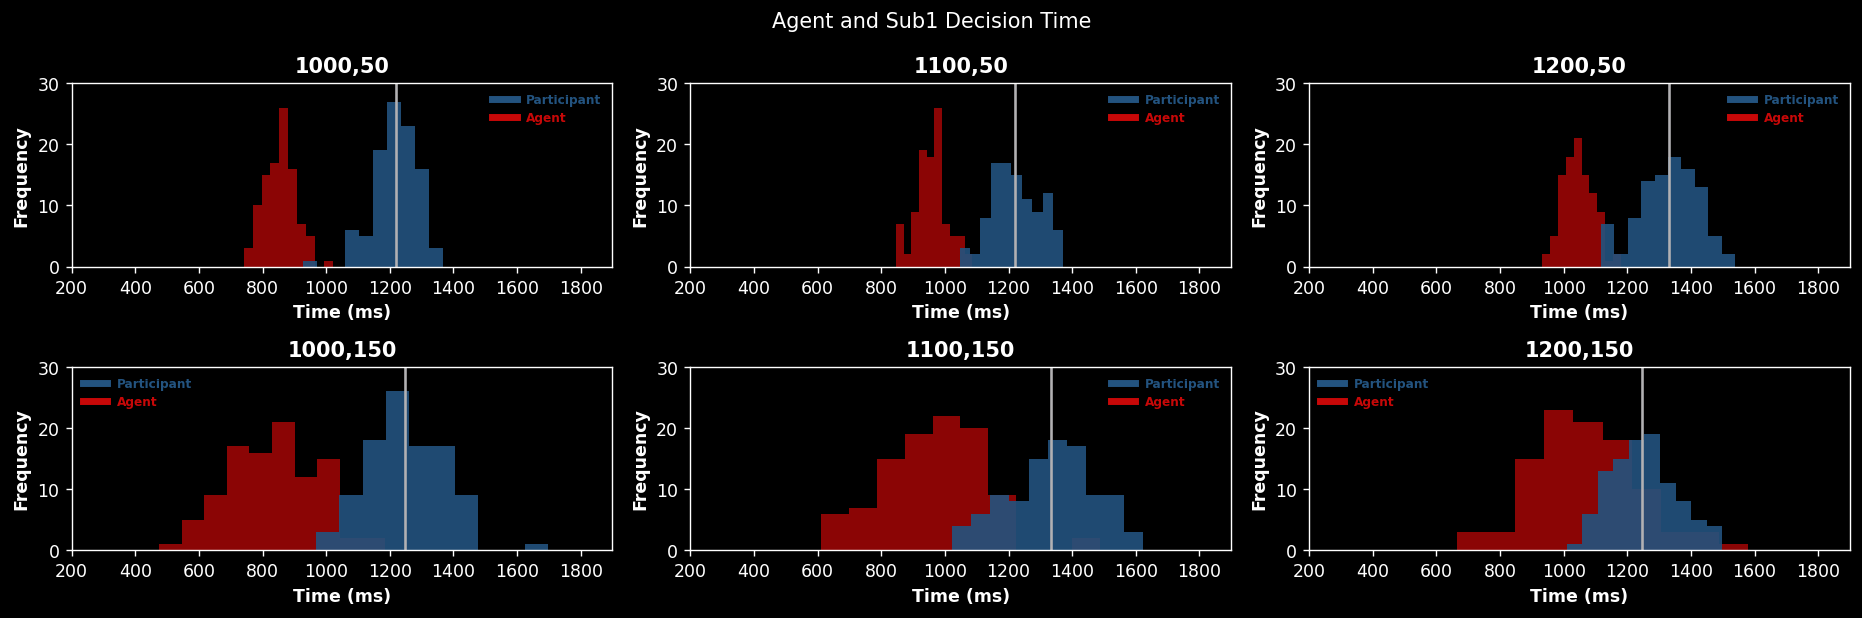

In [72]:
#%% Plot Agent and PLayer LEAVE time distribution
for i in range(num_subjects):
    fig,axs = plt.subplots(2,3, figsize = (15,5), dpi = 125)
    c = -1
    d = 0
    for j in range(num_blocks):
        c+=1
        axs[c,d].hist(agent_left_start_time[i,j,:], histtype = 'stepfilled', color=wheel.dark_red, alpha = 0.7, bins = 10)
        axs[c,d].hist(player_left_start_time[i,j,:], histtype = 'stepfilled', color = wheel.dark_blue, alpha = 0.9, bins = 10)
        axs[c,d].axvline(player_mean_decision_time[i,j], c=wheel.light_grey)
        axs[c,d].set_xlim(200,1900)
        axs[c,d].set_ylim(0,30)
        axs[c,d].set_xlabel('Time (ms)')
        axs[c,d].set_ylabel('Frequency')
        labels = ["Participant", "Agent"]
        colors = [wheel.dark_blue, wheel.dark_red]
        dv.Custom_Legend(axs[c,d], labels, colors, fontsize = 7)
        axs[c,d].set_title(trial_block_titles[j])
        if c == 1:
            d += 1
            c = -1
    fig.suptitle(f'Agent and Sub{i+1} Decision Time', c= 'white')
    plt.tight_layout()
    plt.show()

Agent - Player Decision Time

In [85]:
update_params('w')

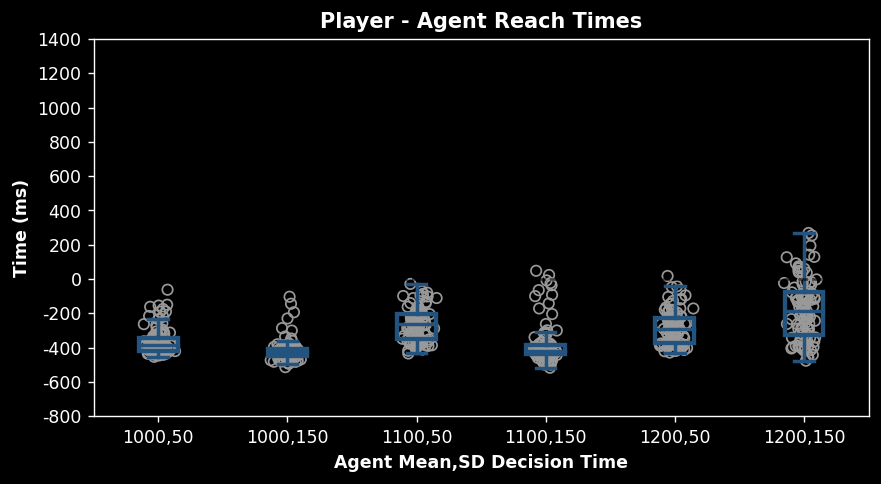

In [86]:
# Find and plot the difference between agent decision time and subject decision time
agent_player_diff_decision_time = agent_left_start_time - player_left_start_time
for i in range(num_subjects):
    plt.figure(dpi = 125, figsize = (8,4))
    ax = plt.subplot()
    xlocs=np.arange(0,num_blocks)
    # Filter out the nans... boxplot can't use nans
    save = False
    ylab='Reach Time (ms)'
    xlab = "Agent Mean Reach Time, SD (ms)"
    title = f'Sub{i+1} Reach Times'
    xlocs = np.arange(0,num_blocks)
    boxplot(agent_player_diff_decision_time[i,:,:].T,xlocs = xlocs,box_widths=0.05, ylocs = np.arange(-200,1400,200), title=f'(Agent - Sub{i+1}) Decision Time')
    ax.scatter(jitter(xlocs,agent_player_diff_decision_time[i,:,:]),agent_player_diff_decision_time[i,:,:], edgecolors= '0.6', facecolors = 'none')
    ax.set_xlabel('Agent Mean,SD Decision Time')
    ax.set_ylabel('Time (ms)')
    ax.set_yticks(np.arange(-800,1600,200))
    ax.set_yticklabels(np.arange(-800,1600,200))
    ax.set_ylim(-800,1400)
    ax.axhline(y=0, color = 'black', linestyle = '--', alpha = 0.6)
    ax.set_title('Player - Agent Reach Times', c= 'white')
    plt.show()

In [64]:
# Plot agent reach time on x axis and the difference betweeen agent and player on the y axis
# This will look at how the level of reaction changes as the agent responds later and later
# Do this for each condition and for each player


In [65]:
#%% Find all the times where the agent went at a time when the participant couldn't use them 
# THis is estimating when they could and could not use the agent... not sure if i like this
could_not_use_left_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
could_not_use_reach_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan

agent_left_start_time = agent_reach_time - 300
fuck_it_time = 1500 - np.nanmean(reaction_movement_time)
could_not_use_agent_index = np.argwhere(agent_left_start_time>fuck_it_time)
for i,j,k in could_not_use_agent_index:
    could_not_use_left_target_time[i,j,k] = player_left_start_time[i,j,k]
    could_not_use_reach_target_time[i,j,k] = player_reach_time[i,j,k]

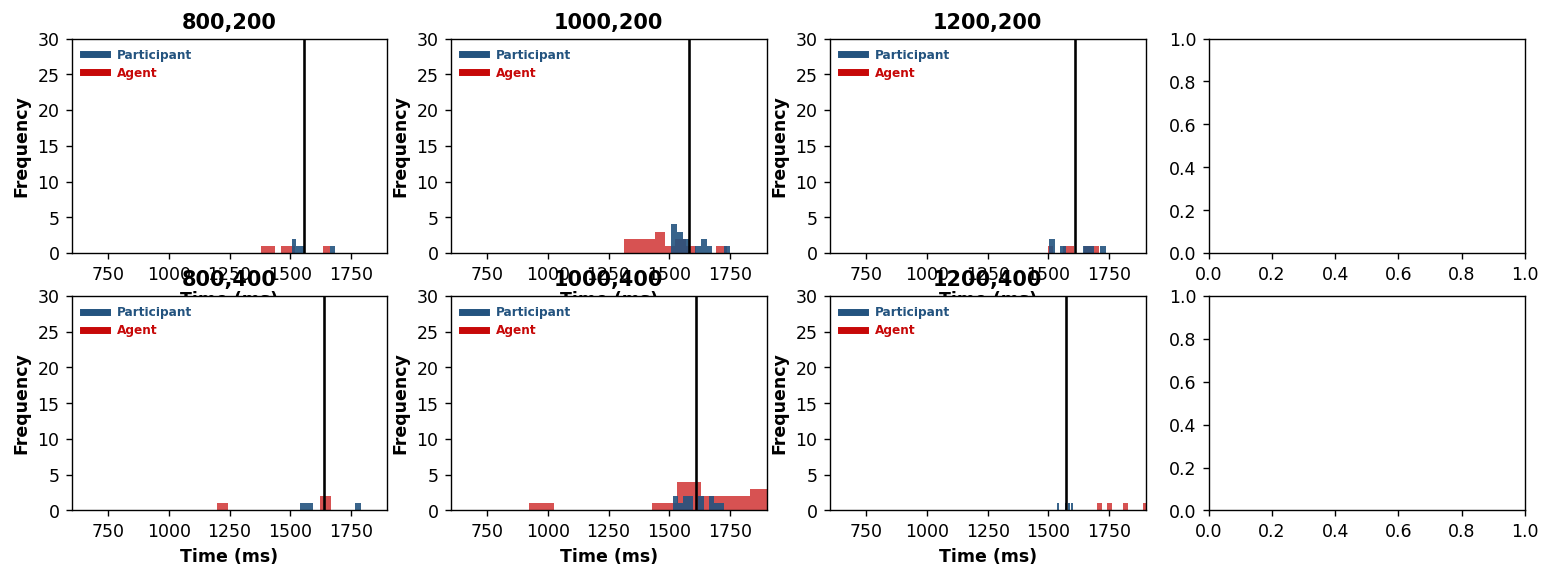

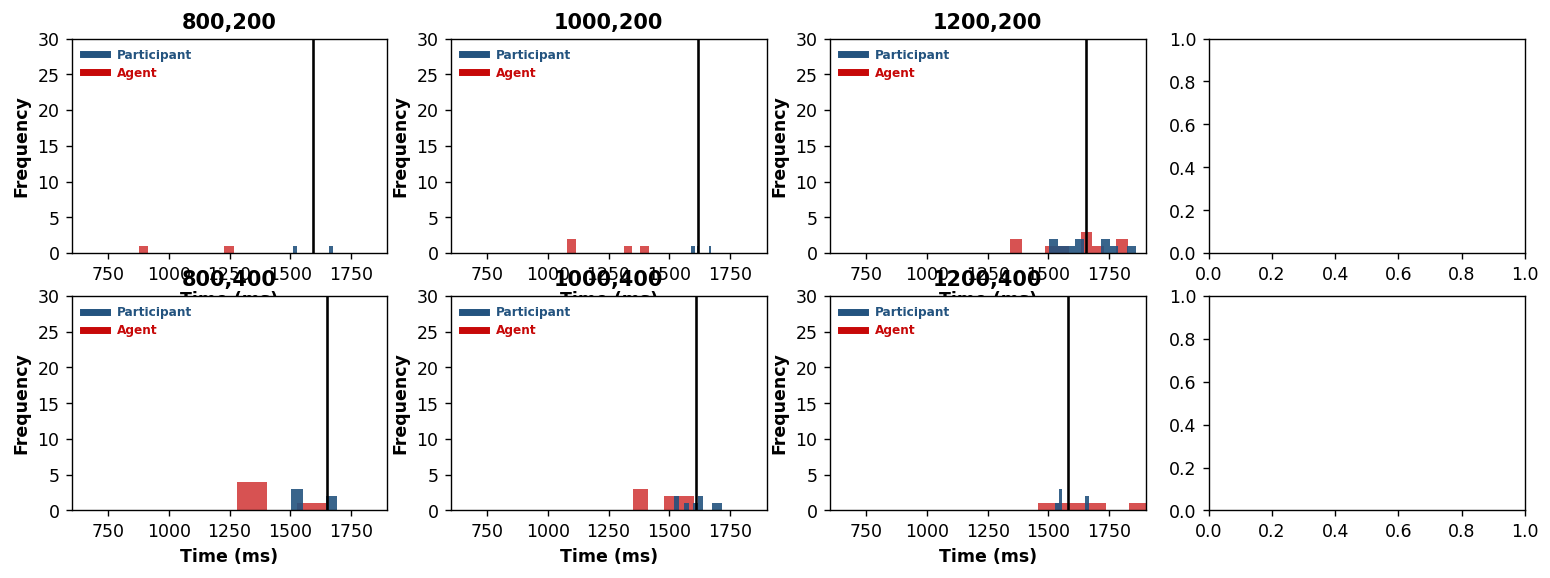

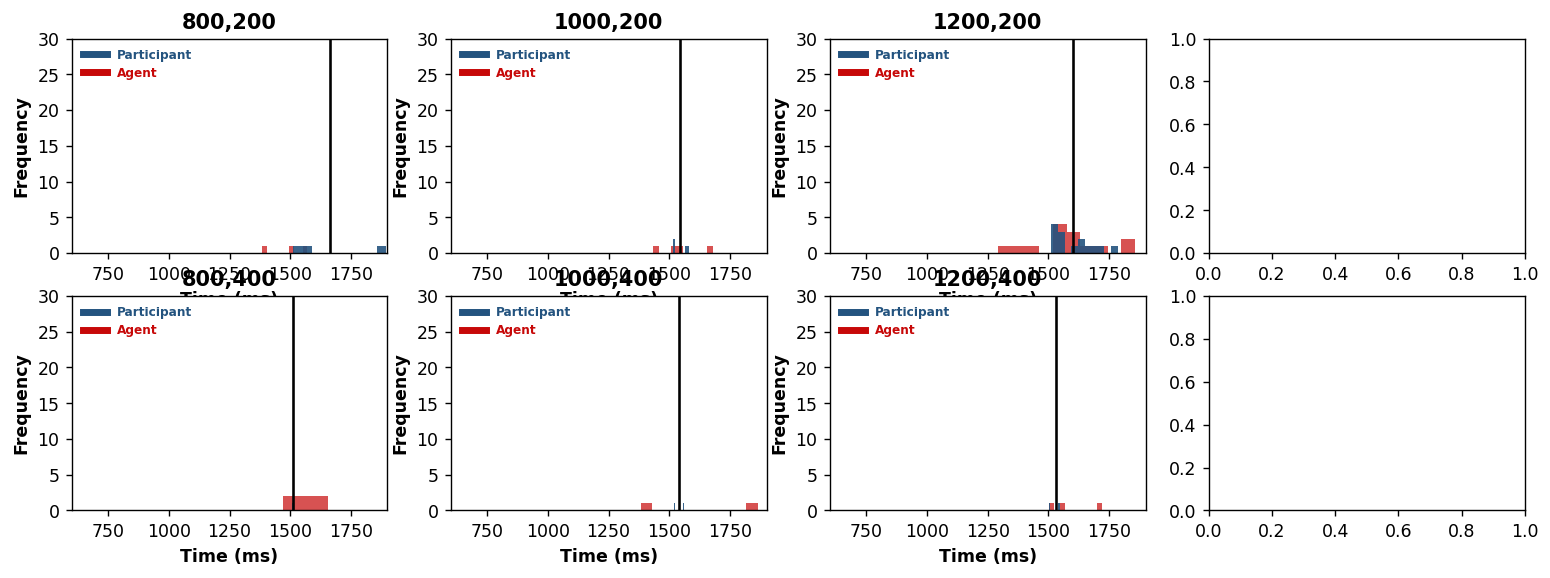

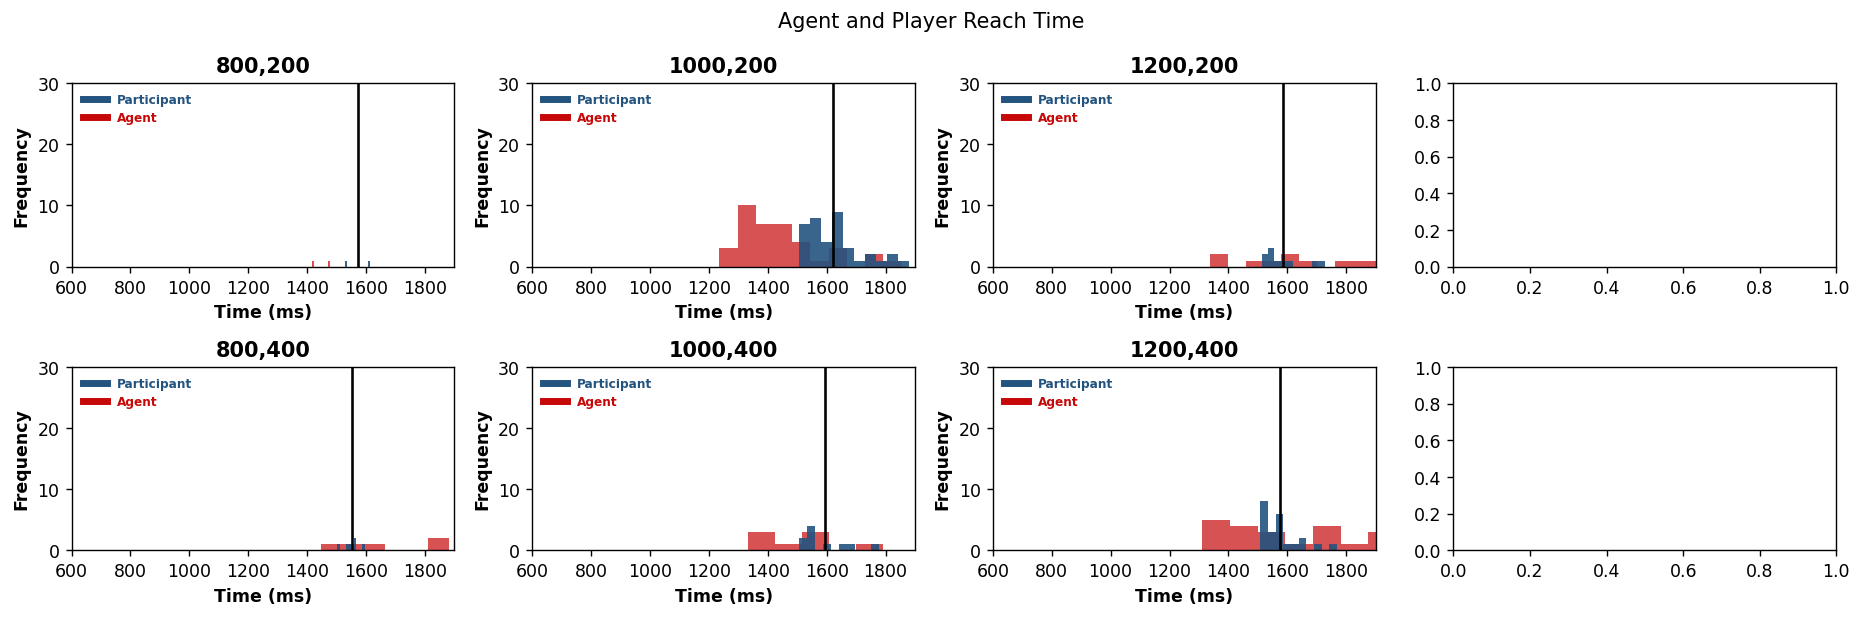

In [66]:
#%% Plot agent and Player reach time histograms when the player didn't make it 
for i in range(num_subjects):
    fig,axs = plt.subplots(2,4, figsize = (15,5), dpi = 125)
    c = -1
    d = 0
    for j in range(num_blocks):
        c+=1
        axs[c,d].hist(agent_reach_time_on_indecisions[i,j,:],histtype = 'stepfilled', color=wheel.dark_red, alpha = 0.7, bins = 10)
        axs[c,d].hist(player_reach_time_on_indecisions[i,j,:], histtype = 'stepfilled', color = wheel.dark_blue, alpha = 0.9, bins = 10)
        axs[c,d].axvline(player_mean_reach_time_on_indecisions[i,j], c= 'black')
        axs[c,d].set_xlim(600,1900)
        axs[c,d].set_ylim(0,30)
        axs[c,d].set_xlabel('Time (ms)')
        axs[c,d].set_ylabel('Frequency')
        labels = ["Participant", "Agent"]
        colors = [wheel.dark_blue, wheel.dark_red]
        dv.Custom_Legend(axs[c,d], labels, colors, fontsize = 7)
        axs[c,d].set_title(trial_block_titles[j])
        if c == 1:
            d += 1
            c = -1
fig.suptitle('Agent and Player Reach Time')
plt.tight_layout()
plt.show()

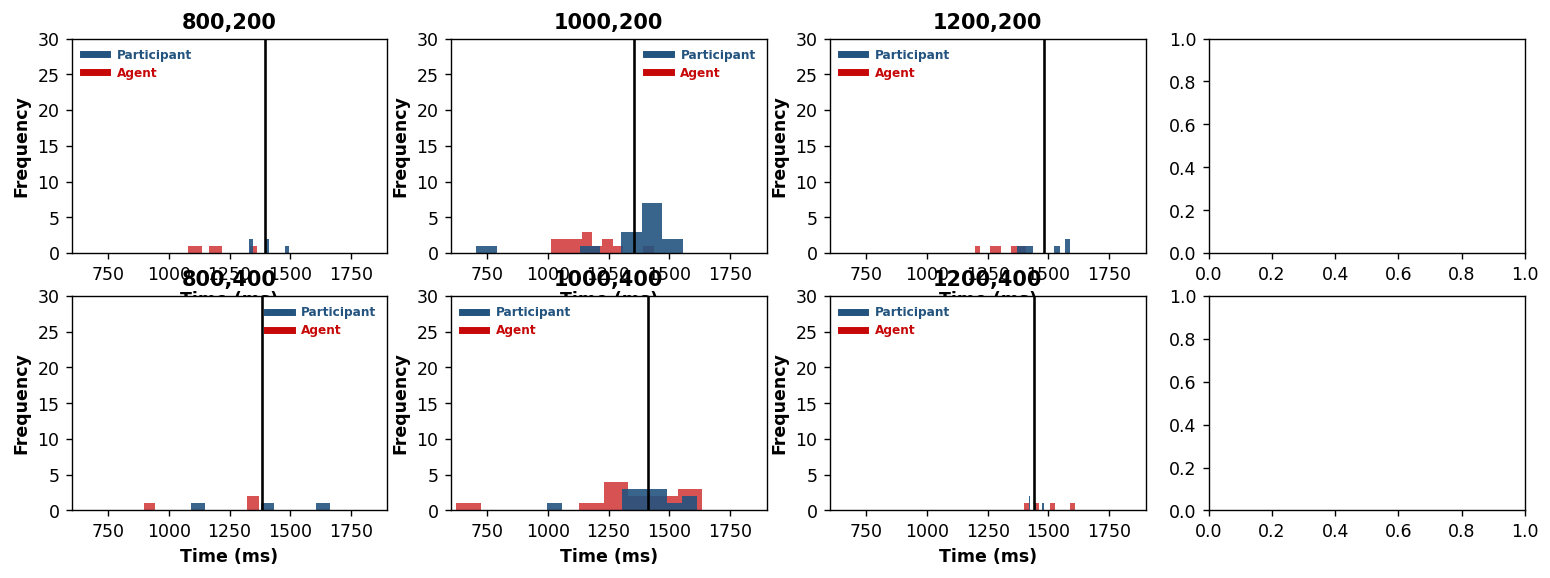

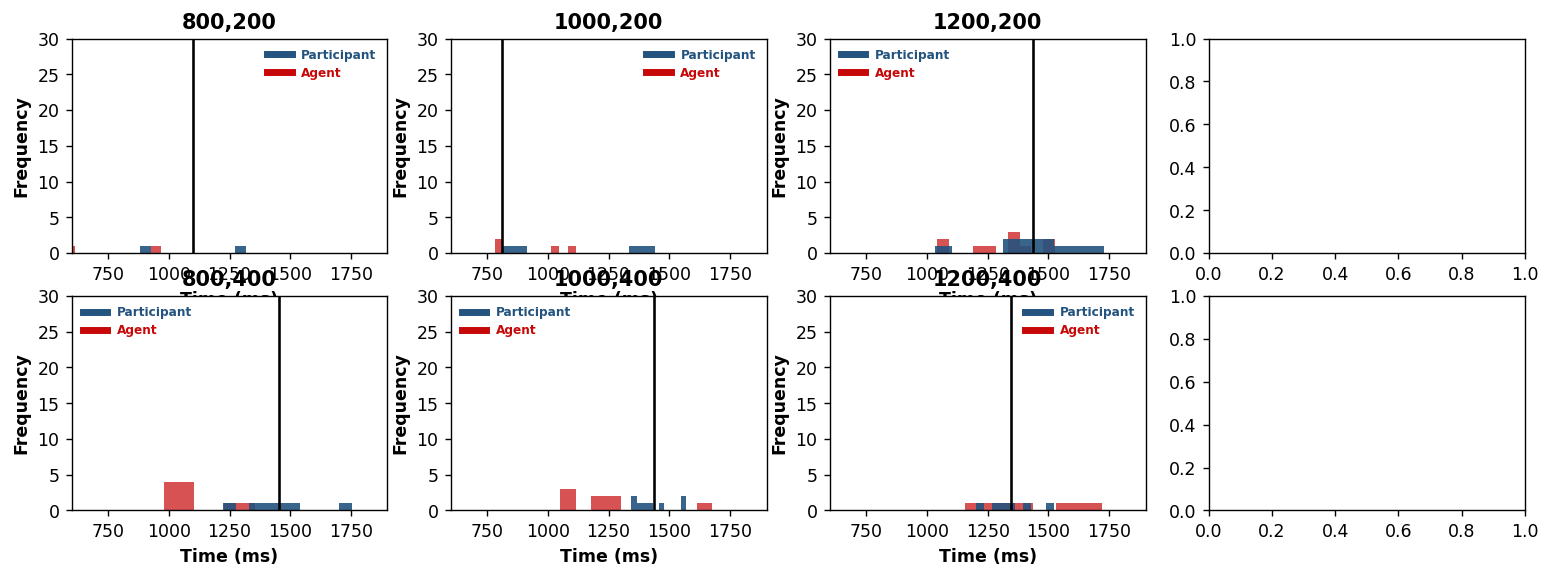

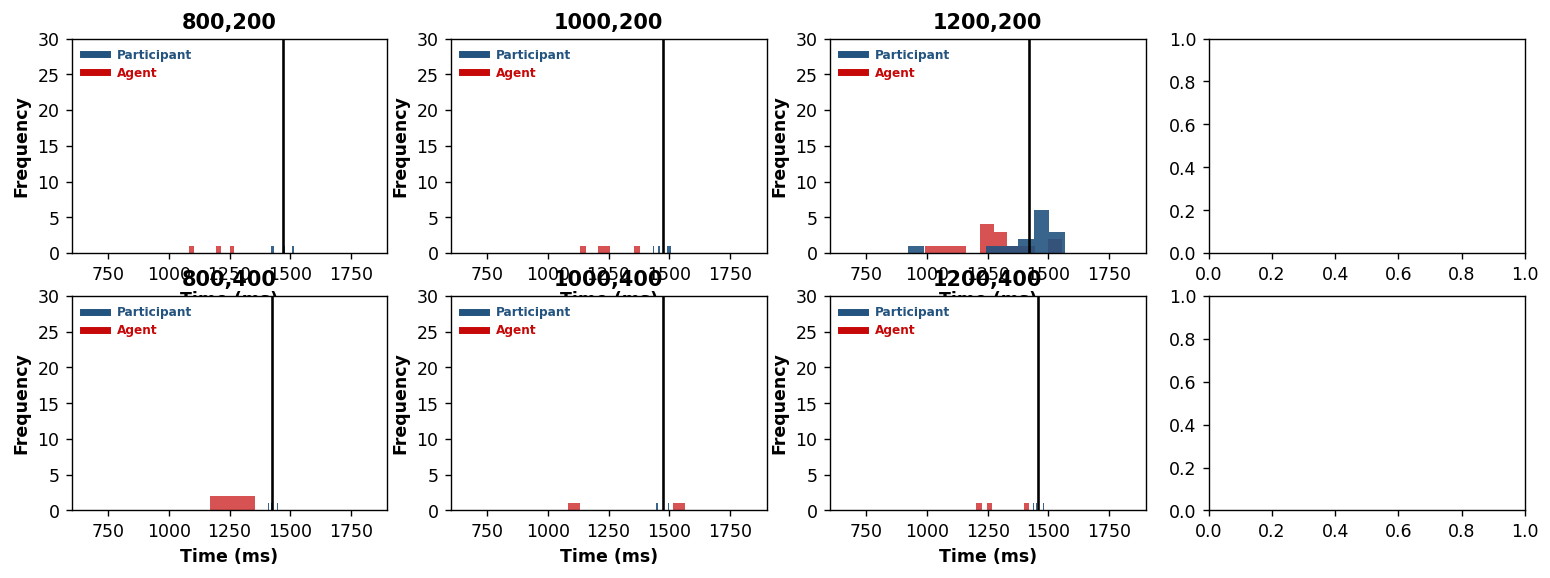

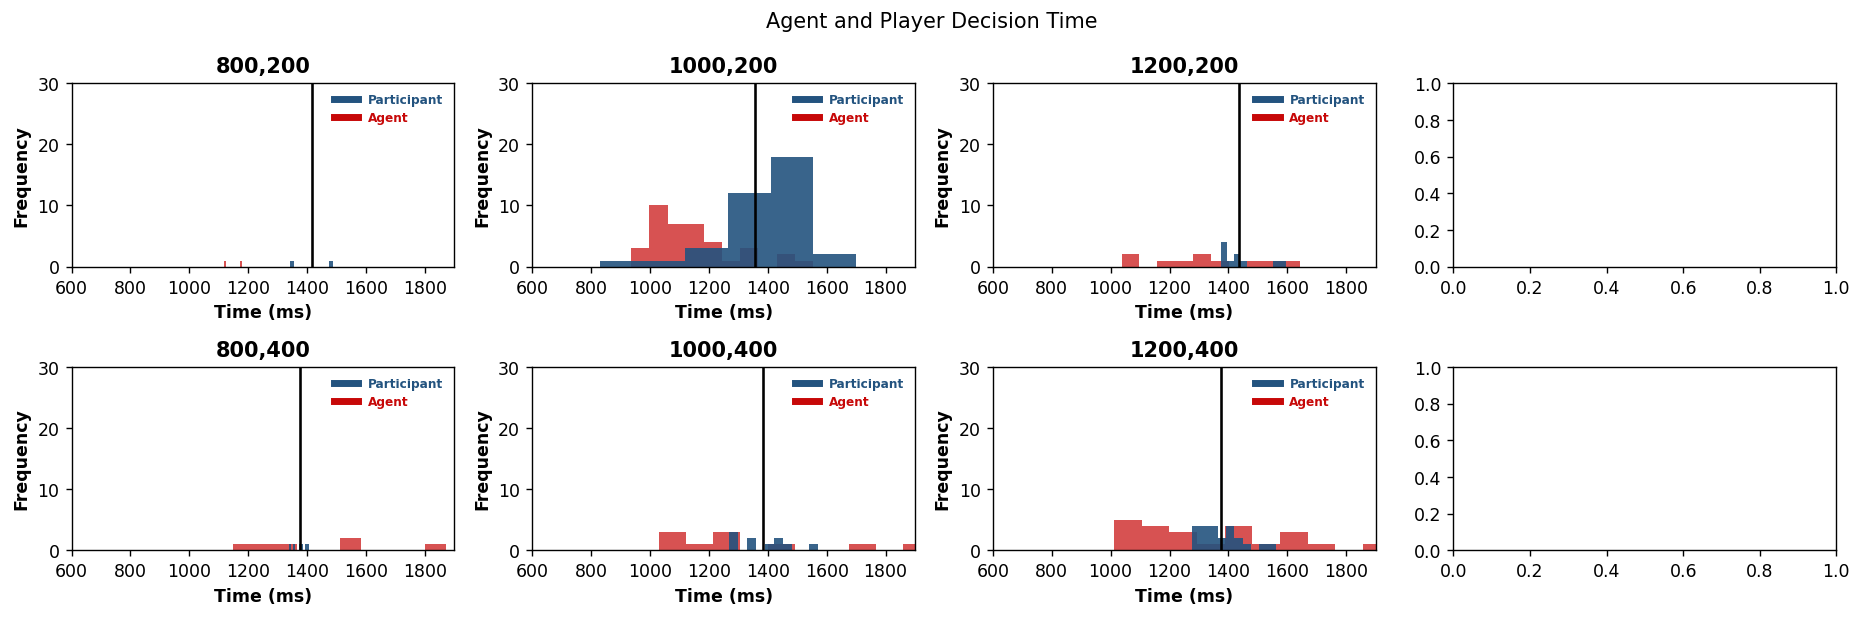

In [67]:
#%% Plot agent and Player decision time histograms when the player didn't make it 
for i in range(num_subjects):
    fig,axs = plt.subplots(2,4, figsize = (15,5), dpi = 125)
    c = -1
    d = 0
    for j in range(num_blocks):
        c+=1
        axs[c,d].hist(agent_reach_time_on_indecisions[i,j,:]-300,histtype = 'stepfilled', color=wheel.dark_red, alpha = 0.7, bins = 10)
        axs[c,d].hist(player_left_time_on_indecisions[i,j,:], histtype = 'stepfilled', color = wheel.dark_blue, alpha = 0.9, bins = 10)
        axs[c,d].axvline(player_mean_left_time_on_indecisions[i,j], c= 'black')
        axs[c,d].set_xlim(600,1900)
        axs[c,d].set_ylim(0,30)
        axs[c,d].set_xlabel('Time (ms)')
        axs[c,d].set_ylabel('Frequency')
        labels = ["Participant", "Agent"]
        colors = [wheel.dark_blue, wheel.dark_red]
        dv.Custom_Legend(axs[c,d], labels, colors, fontsize = 7)
        axs[c,d].set_title(trial_block_titles[j])
        if c == 1:
            d += 1
            c = -1
fig.suptitle('Agent and Player Decision Time')
plt.tight_layout()
plt.show()



Reach time boxplots

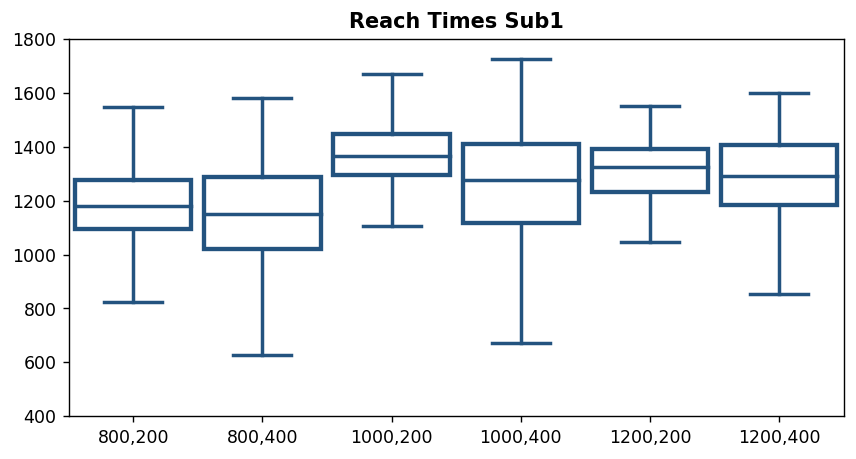

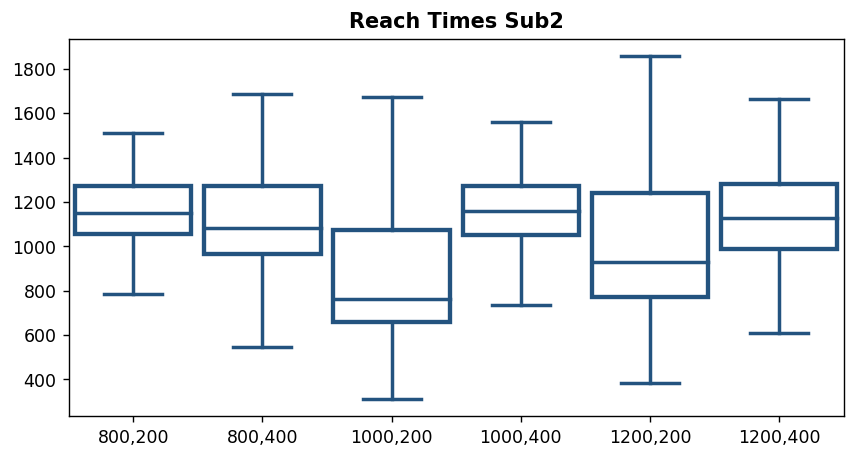

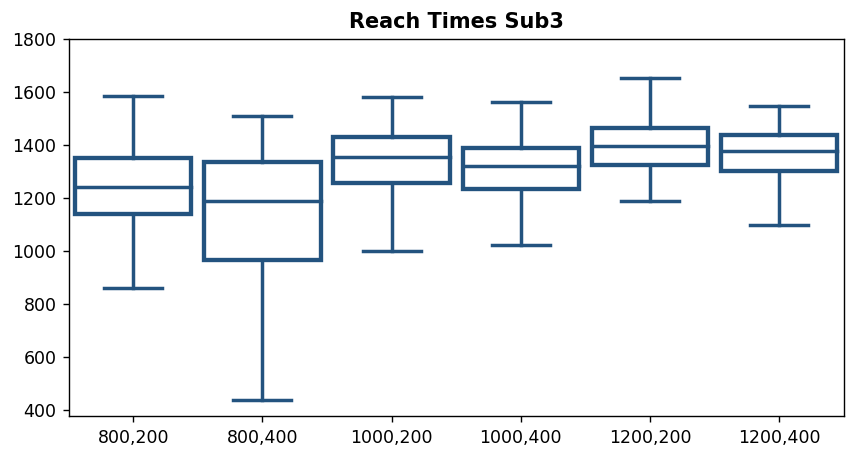

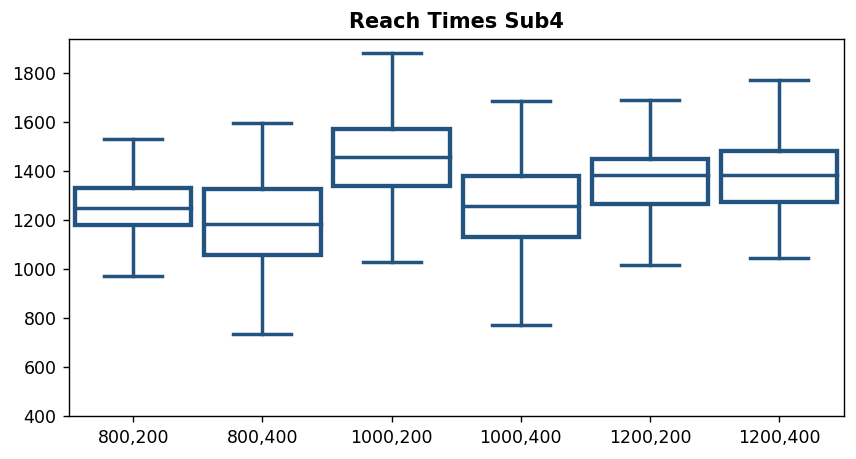

In [69]:
#%% Boxplots of reach times to show how they change with each block 
for i in range(num_subjects):
    plt.figure(dpi = 125, figsize = (8,4))
    ax = plt.subplot()
    # Filter out the nans... boxplot can't use nans
    save = False
    ylab='Reach Time (ms)'
    xlab = "Agent Mean Reach Time, SD (ms)"
    title = f'Sub{i+1} Reach Times'
    boxplot(player_reach_time[i,:,:].T,xlocs=np.arange(0,num_blocks,1),ylocs = np.arange(400,2000,200), title=f'Reach Times Sub{i+1}')

In [ ]:
#%% Boxplots of reach times when they didn't make it to show how they change with each block 
for i in range(num_subjects):
    plt.figure(dpi = 125, figsize = (8,4))
    ax = plt.subplot()
    # Filter out the nans... boxplot can't use nans
    save = False
    ylab='Reach Time (ms)'
    xlab = "Agent Mean Reach Time, SD (ms)"
    title = f'Sub{i+1} Reach Times'
    boxplot(player_reach_time_on_indecisions[i,:,:],xlocs=np.arange(0,num_blocks,1),ylocs = np.arange(400,2000,200), title=f'Reach Times on Indecisions Sub{i+1}')

In [ ]:
#%% Boxplots of decisions times to show how they change with each block 
for i in range(num_subjects):
    plt.figure(dpi = 125, figsize = (8,4))
    ax = plt.subplot()
    # Filter out the nans... boxplot can't use nans
    save = False
    ylab='Reach Time (ms)'
    xlab = "Agent Mean Reach Time, SD (ms)"
    title = f'Sub{i+1} Reach Times'
    boxplot(player_left_start_time[i,:,:],xlocs=np.arange(0,num_blocks,1),ylocs = np.arange(400,2000,200), title=f'Decision Times Sub{i+1}')


In [ ]:
#%% Overall Wins vs. indecisions scatter
# The greater indecisions, the less wins people should have
# A greater number of incorrect decision

 Gamble Analysis
 
 If the difference between agent left start time and player left start time is less than 200 (or individual reaction time), then this is labeled as a gamble


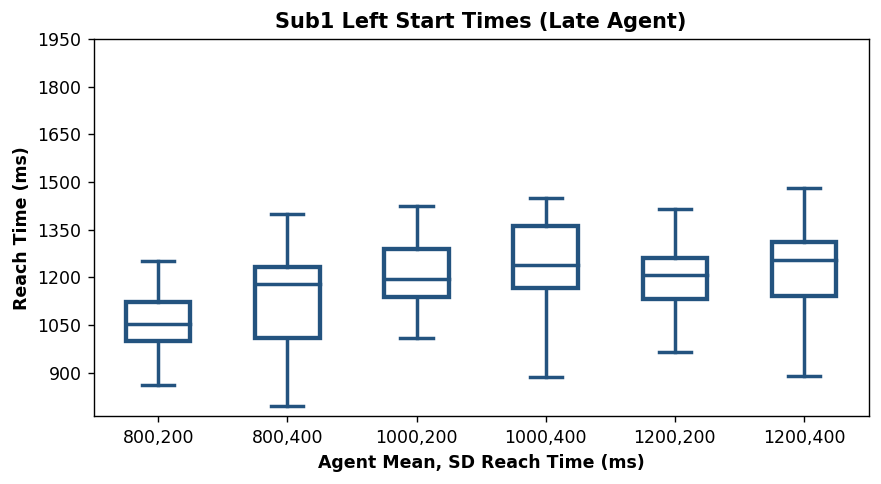

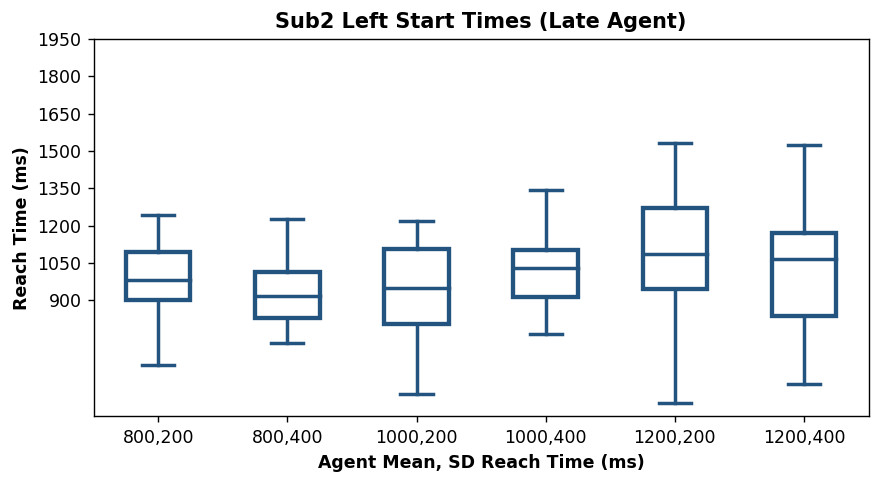

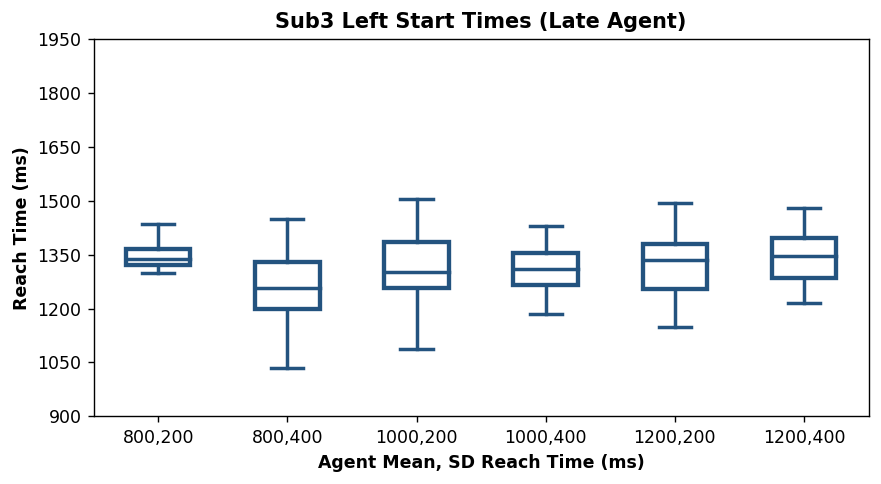

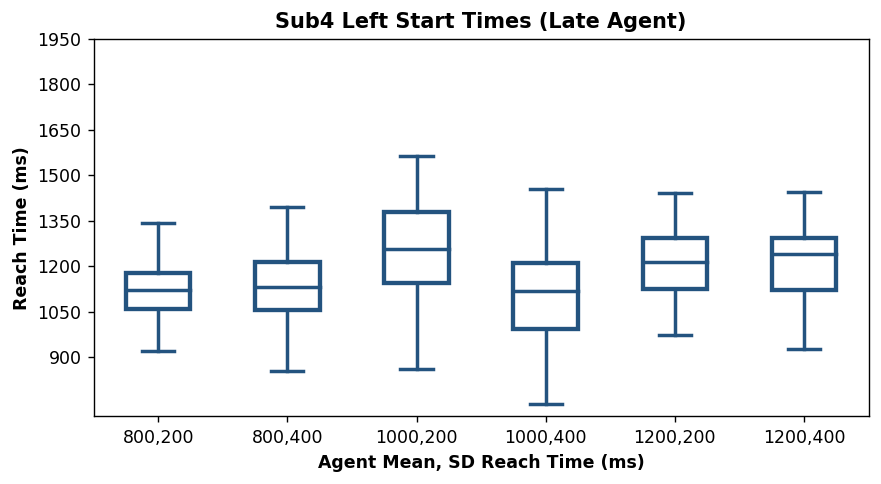

In [122]:
#%% Boxplots of left times when they didn't use agents movement
for i in range(num_subjects):
    mask = ~np.isnan(gamble_reach_target_time[i,:,:])
    filtered_gamble_reach_time = [d[m] for d,m in zip(gamble_reach_target_time[i,:,:], mask)]
    mask = ~np.isnan(gamble_left_target_time[i,:,:])
    filtered_gamble_left_time = [d[m] for d,m in zip(gamble_left_target_time[i,:,:], mask)]
    # Filter out the nans... boxplot can't use nans
    save = False
    ylab='Reach Time (ms)'
    xlab = "Agent Mean, SD Reach Time (ms)"
    title = f'Sub{i+1} Left Start Times (Late Agent)'
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
    plt.rcParams.update(params)
    plt.figure(dpi = 125, figsize = (8,4))
    X_locations = np.arange(0, num_blocks)
    Y_locations = np.arange(900,2050,150)
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    #total = np.concatenate((data1, data2))
    #ax.plot(X_locations, did_not_use_left_target_time[i,:,:],color = '0.8', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    #ax.plot(X_locations+0.075, data2.T,color = '0.8', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    #bplot two  #block number, dyad, right/left
    ax.boxplot(filtered_gamble_left_time, positions=X_locations, patch_artist=True, boxprops = two_props, whiskerprops = two_whisk, 
                capprops = two_cap, medianprops = two_median, showfliers=False)#, widths = (0.15,0.15,0.15,0.15,0.15,0.15))
    #bplot three
    #ax.boxplot(data2, positions = X_locations+0.075, patch_artist=True, boxprops = three_props, whiskerprops = three_whisk,
     #            capprops = three_cap, medianprops=three_median, showfliers = False, widths = (0.15,0.15,0.15))
    ax.set_xticks(X_locations)
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(Y_locations)
    ax.set_yticklabels(Y_locations) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    
    # labels = ["Full Feedback", "Feedback Loss"]
    # colors = [wheel.dark_blue, wheel.dark_red]
    # dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+'\\Figures\\'+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

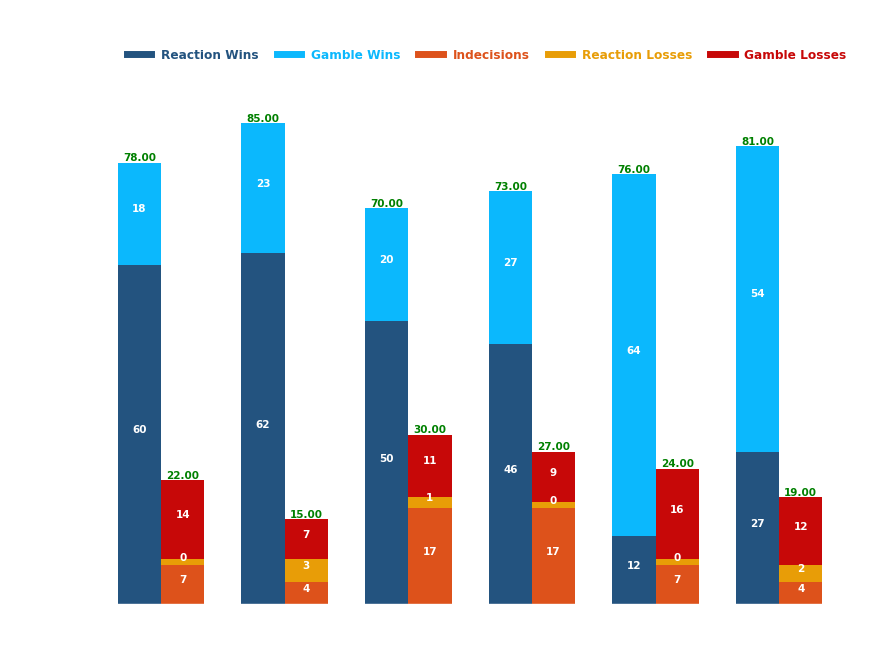

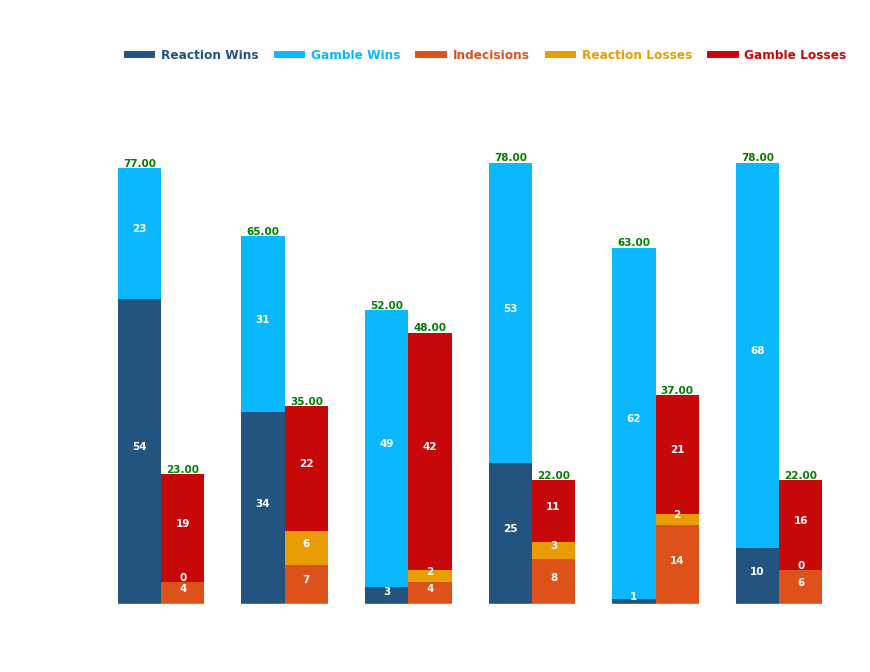

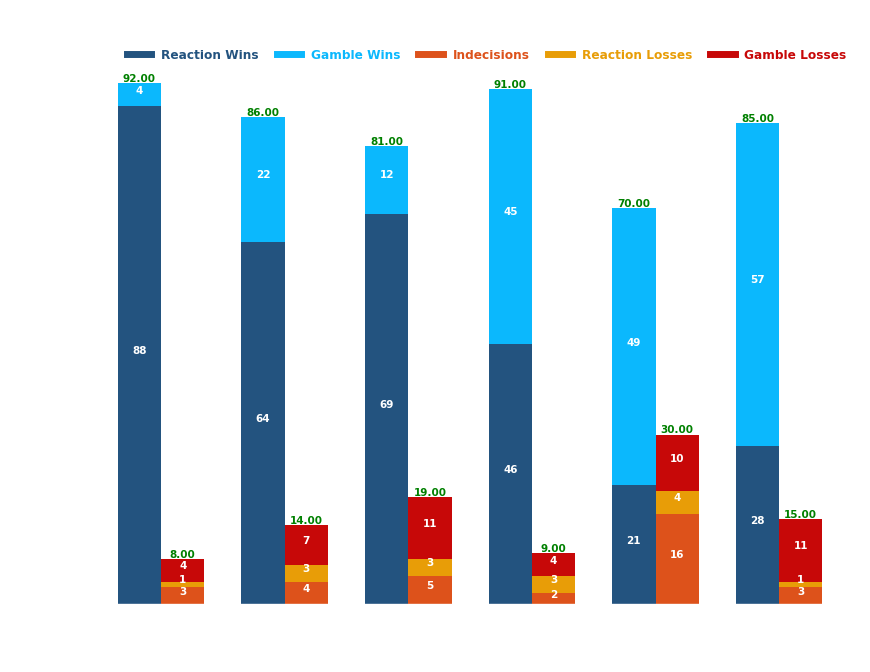

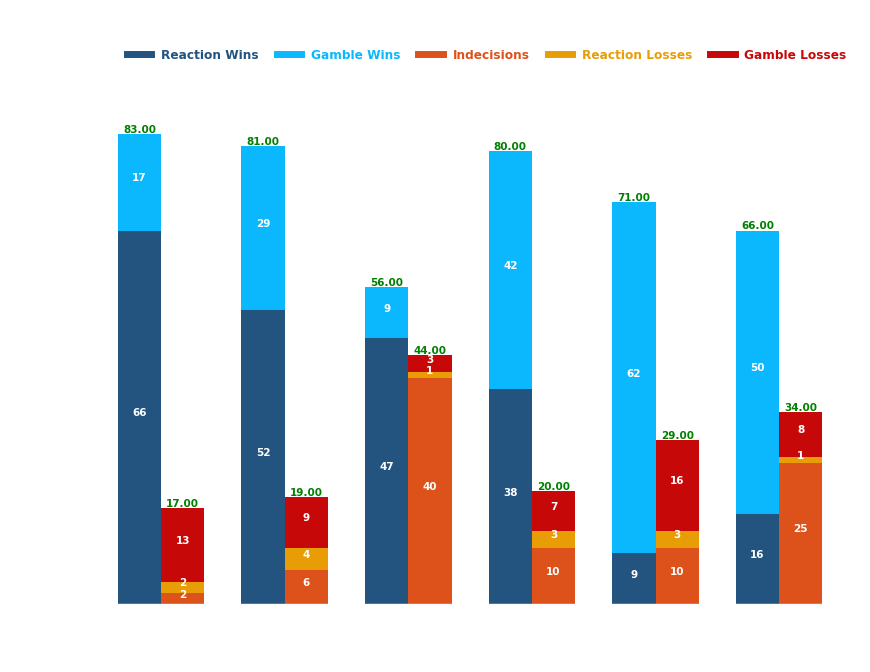

In [134]:
#%% Plot wins and indecisions for gambles and reactions
# Remember that gamble wins could be because of the agent not making it there!!!!!
for i in range(num_subjects):
    subnum = i
    plt.figure(dpi = 125, figsize= (8,6))
    ax = plt.subplot()
    update_params('w')
    xlocs = np.arange(num_blocks)
    xlabs = trial_block_titles
    width = 0.35
    rect1 = ax.bar(xlocs - width/2 ,perc_reaction_wins[subnum,:], width = width, label = 'Reaction Wins', color = wheel.dark_blue)
    rect2 = ax.bar(xlocs - width/2 ,perc_gamble_wins[subnum,:], width = width, label = 'Gamble Wins', color = wheel.light_blue, bottom = perc_reaction_wins[subnum,:])
    rect3 = ax.bar(xlocs + width/2, perc_player_indecisions[subnum,:], width = width, label = 'Indecisions', color = wheel.autumn)
    rect4 = ax.bar(xlocs + width/2, perc_reaction_losses[subnum,:], width = width, label = 'Reaction Losses', color = wheel.orange, bottom = perc_player_indecisions[subnum,:])
    rect5 = ax.bar(xlocs + width/2, perc_gamble_losses[subnum,:], width = width, label = 'Gamble Losses', color = wheel.dark_red, bottom = perc_player_indecisions[subnum,:]+perc_reaction_losses[subnum,:])

    ax.set_xticks(xlocs)
    ax.set_xticklabels(xlabs)
    ax.set_xlabel('Mean,SD Agent Reach Time')
    ax.set_ylabel('Percent')
    ax.set_ylim(0,100)

    labels = ["Reaction Wins","Gamble Wins", "Indecisions", "Reaction Losses", "Gamble Losses"]
    colors = [wheel.dark_blue, wheel.light_blue, wheel.autumn, wheel.orange, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 7, ncol=5,columnspacing=1.5)
    ax.set_title(f'Subject {i+1}')
    for r1, r2, r3, r4, r5 in zip(rect1, rect2, rect3, rect4, rect5):
        h1 = r1.get_height()
        h2 = r2.get_height()
        h3 = r3.get_height()
        h4 = r4.get_height()
        h5 = r5.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r3.get_x() + r3.get_width() / 2., h3 / 2., "%d" % h3, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r4.get_x() + r4.get_width() / 2., h3+h4 / 2., "%d" % h4, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r5.get_x() + r5.get_width() / 2., h3+h4+h5 / 2., "%d" % h5, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2, f'{h1+h2:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
        plt.text(r4.get_x() + r2.get_width() / 2., h3+h4+h5, f'{h3+h4+h5:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
    plt.savefig(PATH+'\\Individual_Figures\\'+f'Sub{i+1}\\'+'reaction_gamble_bar_plots', dpi = 400, transparent = True, bbox_inches='tight')



In [ ]:
#%% Correlation between agent reach time and player reach time
for i in range(num_subjects):
    for j in range(num_blocks):
        # Linear regression 
        mask = ~np.isnan(agent_reach_time[i,j,:]) & ~np.isnan(player_reach_time[i,j,:])
        lobf = stats.linregress(agent_reach_time[i,j,mask],player_reach_time[i,j,mask])
        x = np.arange(1000,2200,1)
        y = lobf.slope*x + lobf.intercept
        r = stats.spearmanr(agent_reach_time[i,j,mask],player_reach_time[i,j,mask])
        corr = r.correlation
        pval = r.pvalue
        plt.figure(dpi = 125)
        ax = plt.subplot()
        ax.scatter(agent_reach_time[i,j,:],player_reach_time[i,j,:])
        ax.plot(x,y, c = 'red')
        ax.text(1500,2000, f'p = {pval:0.3f}')
        ax.text(1500,1950, fr'$\rho$ = {corr:0.3f}')
        ax.axvline(x = 1500)
        ax.axhline(y = 1500)
        ax.set_title(trial_block_titles[j])
        ax.set_xlabel('Agent Reach Time (ms)')
        ax.set_ylabel('Player Reach Time (ms)')
        ax.set_xlim(1000,2200)
        ax.set_ylim(1000,2200)

In [ ]:
#%% Correlation between agent leave time and player leave time
for i in range(num_subjects):
    for j in range(num_blocks):
        mask = ~np.isnan(agent_left_start_time[i,j,:]) & ~np.isnan(player_left_start_time[i,j,:])
        lobf = stats.linregress(agent_left_start_time[i,j,mask],player_left_start_time[i,j,mask])
        x = np.arange(1000,2200,1)
        y = lobf.slope*x + lobf.intercept
        r = stats.spearmanr(agent_left_start_time[i,j,mask],player_left_start_time[i,j,mask])
        corr = r.correlation
        pval = r.pvalue
        plt.figure(dpi = 125)
        ax = plt.subplot()
        ax.scatter(agent_left_start_time[i,j,:],player_left_start_time[i,j,:])
        ax.plot(x,y, c = 'red')
        ax.text(1500,2000, f'p = {pval:0.3f}')
        ax.text(1500,1950, fr'$\rho$ = {corr:0.3f}')
        ax.axvline(x = 1500)
        ax.axhline(y = 1500)
        ax.set_title(trial_block_titles[j])
        ax.set_xlabel('Agent Left Start Time (ms)')
        ax.set_ylabel('Player Left Start Time (ms)')
        ax.set_xlim(600,2000)
        ax.set_ylim(600,2000)

In [ ]:
mean_of_each_condition_each_bin[7,:] # This is the 0th block and then all the mean reach times for each agent reach time bin 

In [ ]:
np.shape(mean_diff_decision_time)

(4, 8)

In [ ]:
#%% Create some type of distribution that predicts if someone will make it given an agent time
# This could be machine learning?

Timing Correlations

In [ ]:
player_mean_decision_time

array([[1201.15      ,  832.575     , 1159.4625    , 1064.725     ,
        1053.7375    , 1153.3125    , 1090.2       , 1098.2625    ],
       [1185.3875    , 1172.8       , 1226.6875    , 1218.075     ,
        1237.7375    , 1087.2125    , 1168.8875    , 1096.6875    ],
       [1205.4375    , 1187.95      , 1233.        , 1237.275     ,
         614.5       ,  692.0125    ,  646.025     ,  555.8875    ],
       [1244.375     , 1165.4875    , 1155.8625    , 1132.5625    ,
        1186.84810127,  865.1875    , 1205.65      , 1128.275     ]])

In [ ]:
np.repeat(timing_sd,repeats=)

array([1201.15      ,  832.575     , 1159.4625    , 1064.725     ,
       1053.7375    , 1153.3125    , 1090.2       , 1098.2625    ,
       1185.3875    , 1172.8       , 1226.6875    , 1218.075     ,
       1237.7375    , 1087.2125    , 1168.8875    , 1096.6875    ,
       1205.4375    , 1187.95      , 1233.        , 1237.275     ,
        614.5       ,  692.0125    ,  646.025     ,  555.8875    ,
       1244.375     , 1165.4875    , 1155.8625    , 1132.5625    ,
       1186.84810127,  865.1875    , 1205.65      , 1128.275     ])

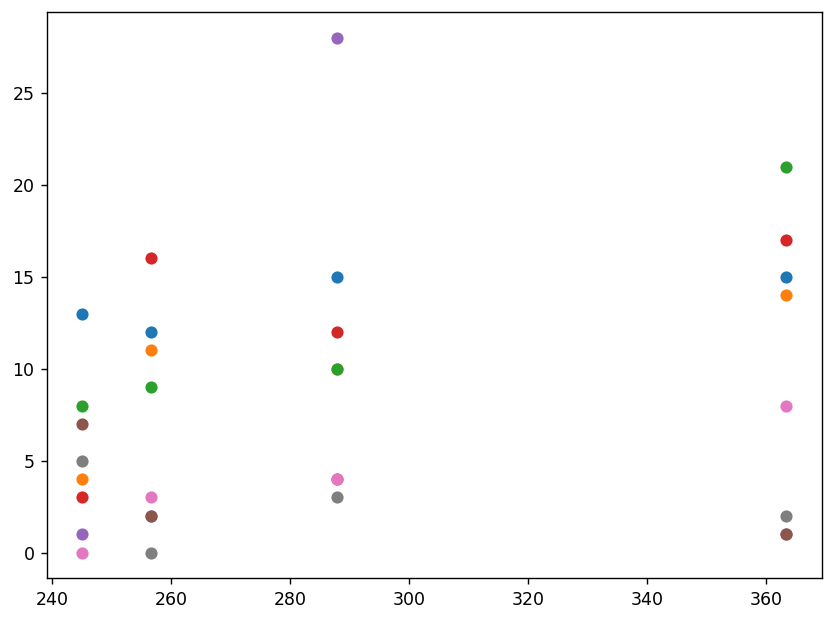

In [ ]:
fig,ax = plt.subplots(dpi = 125, figsize = (8,6))
for j in range(num_blocks):
    ax.scatter(rt_mean,player_indecisions[:,j])

plt.show()

Trial by Trial Analysis


Text(0.5, 1.0, 'Trial by Trial Decision Times')

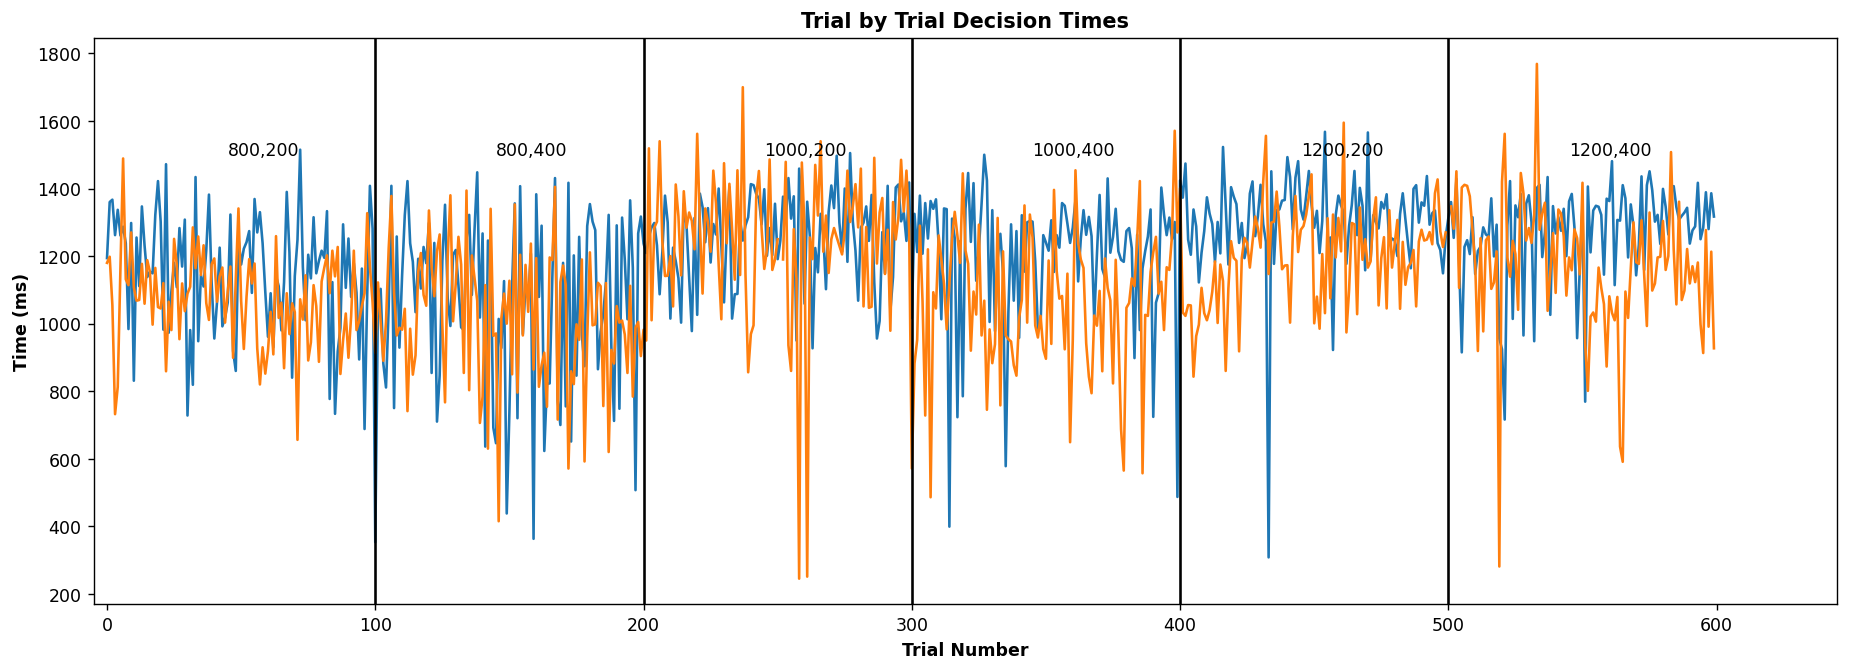

In [71]:
fig,ax = plt.subplots(dpi = 125, figsize = (18,6))
xlocs = np.arange(0,tot_trials,1)
ax.plot(xlocs, player_decision_time_all_conditions[2,:])
ax.plot(xlocs, player_decision_time_all_conditions[3,:])

y = 1500
c=0
for i in range(num_blocks):
    c+=100
    x=c-55
    if i < num_blocks-1:
        ax.axvline(x=c, c= 'black')
    ax.text(x,y, trial_block_titles[i])
ax.set_xlim(-5,645)
ax.set_xlabel('Trial Number')
ax.set_ylabel('Time (ms)')
ax.set_title('Trial by Trial Decision Times')

Trial by Trial Gambles